In [ ]:
# Downloading the movielens datasets and Book-Crossing Dataset

# Movielens Dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
# Book-Crossing Dataset
!wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
!unzip BX-CSV-Dump.zip

--2022-09-21 20:47:14--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2022-09-21 20:47:14 (6.59 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
--2022-09-21 20:47:14--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to

In [ ]:
# Importing reuired packages
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense, Dropout, merge
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Reading required files
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
book_rating_data = pd.read_csv("BX-Book-Ratings.csv", encoding='latin1', sep=';')

In [ ]:
# Snapshot of the loaded dataset
print(ratings.head())
print(movies.head())
print(book_rating_data.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X           

In [ ]:
# Function to create index on the basis of user-id and item-id
def user_item_index(col):
  user_item_ids = col.unique().tolist()
  user_item_idx = {x: i for i, x in enumerate(user_item_ids)}
  idx_user_item = {i: x for i, x in enumerate(user_item_ids)}
  return user_item_idx

In [ ]:
# Implementing the indexing function on user-id and item-id
ratings["user"] = ratings["userId"].map(user_item_index(ratings["userId"]))
ratings["item"] = ratings["movieId"].map(user_item_index(ratings["movieId"]))


book_rating_data["user"] = book_rating_data["User-ID"].map(user_item_index(book_rating_data["User-ID"]))
book_rating_data["item"] = book_rating_data["ISBN"].map(user_item_index(book_rating_data["ISBN"]))
book_rating_data.rename(columns = {'Book-Rating':'rating'}, inplace=True)

In [ ]:
print(ratings.head())
print(book_rating_data.head())

   userId  movieId  rating  timestamp  user  item
0       1        1     4.0  964982703     0     0
1       1        3     4.0  964981247     0     1
2       1        6     4.0  964982224     0     2
3       1       47     5.0  964983815     0     3
4       1       50     5.0  964982931     0     4
   User-ID        ISBN  rating  user  item
0   276725  034545104X       0     0     0
1   276726  0155061224       5     1     1
2   276727  0446520802       0     2     2
3   276729  052165615X       3     3     3
4   276729  0521795028       6     3     4


In [ ]:
num_users = len(ratings["userId"].unique().tolist())
num_items = len(ratings["movieId"].unique().tolist())

br_num_users = len(book_rating_data["User-ID"].unique().tolist())
br_num_items = len(book_rating_data["ISBN"].unique().tolist())


print(num_users)
print(num_items)
print(br_num_users)
print(br_num_items)

610
9724
105283
340556


#**Implementing GMF (Element-wise product)**

In [ ]:
# Change the dataset name as per the interest - movielens dataset > ratings, book rating dataset > book_rating_data

rating = ratings  #Change it to different dataset accordingly
rating["rating"] = rating["rating"].values.astype(np.float32)

min_rating = min(rating["rating"])
max_rating = max(rating["rating"])

# Creation of train and validation dataset
data = rating.sample(frac=1, random_state=1)
x = data[["user","item"]].values
y = data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#y = data["rating"]


train_indices = int(0.7 * data.shape[0])

x_train, x_val, y_train, y_val = (x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:])

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(70585, 2)
(70585,)
(30251, 2)
(30251,)


In [ ]:
# Model creation using Generalized Matrix Factorisation Methodology
class GMF(keras.Model):
  def __init__(self, num_users, num_items, embedding_size, **kwargs):
    super(GMF, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_size = embedding_size
    self.user_embed = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.item_embed = layers.Embedding(
        num_items,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.item_bias = layers.Embedding(num_items, 1)
    self.output_layer = Dense(1, activation='sigmoid')



  def call(self, inputs):
    user_vector = self.user_embed(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    item_vector = self.item_embed(inputs[:,1])
    item_bias = self.item_bias(inputs[:,1])
    user_item_interaction = user_vector * item_vector
    final_input = user_item_interaction + user_bias + item_bias
    final_output = self.output_layer(final_input)


    return final_output

In [ ]:
# Creating training loop for the purpose of training the model

Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = GMF(num_users, num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.0001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])

Epoch 1/5
552/552 [==============================] - 3s 4ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 2/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6925 - val_loss: 0.6923
Epoch 3/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6922 - val_loss: 0.6920
Epoch 4/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6920 - val_loss: 0.6918
Epoch 5/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 1/5
552/552 [==============================] - 3s 4ms/step - loss: 0.6943 - val_loss: 0.6941
Epoch 2/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6938 - val_loss: 0.6937
Epoch 3/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 4/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 5/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 1/5


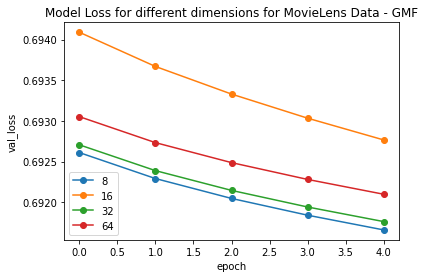

In [ ]:
# 'new_output' is a dataframe with stacked validation losses fro different Embedding Dimensions
val_losses_data_ML = pd.DataFrame(new)
val_losses_data_ML['Dim'] = Embedding_size
val_losses_data_ML.set_index(['Dim'])


for i, v in val_losses_data_ML.iterrows():
  plt.plot(val_losses_data_ML['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for MovieLens Data - GMF')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_ML['Dim'], loc='lower left')
plt.show()

GMF for Book Rating Dataset

In [ ]:
Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = GMF(br_num_users, br_num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.0001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/5
276/276 [==============================] - 8s 5ms/step - loss: 0.6973 - val_loss: 0.6971
Epoch 2/5
276/276 [==============================] - 1s 5ms/step - loss: 0.6969 - val_loss: 0.6968
Epoch 3/5
276/276 [==============================] - 1s 5ms/step - loss: 0.6966 - val_loss: 0.6965
Epoch 4/5
276/276 [==============================] - 1s 5ms/step - loss: 0.6963 - val_loss: 0.6963
Epoch 5/5
276/276 [==============================] - 1s 5ms/step - loss: 0.6961 - val_loss: 0.6961
Epoch 1/5
276/276 [==============================] - 3s 7ms/step - loss: 0.6988 - val_loss: 0.6986
Epoch 2/5
276/276 [==============================] - 2s 6ms/step - loss: 0.6985 - val_loss: 0.6984
Epoch 3/5
276/276 [==============================] - 2s 7ms/step - loss: 0.6983 - val_loss: 0.6982
Epoch 4/5
276/276 [==============================] - 2s 6ms/step - loss: 0.6981 - val_loss: 0.6981
Epoch 5/5
276/276 [==============================] - 2s 7ms/step - loss: 0.6980 - val_loss: 0.6979
Epoch 1/5


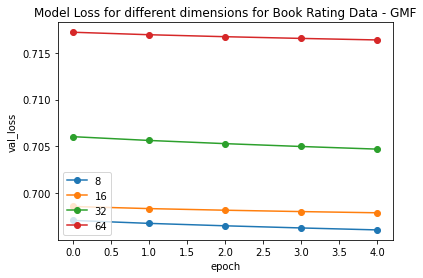

In [ ]:
# 'new_output' is a dataframe with stacked validation losses fro different Embedding Dimensions
val_losses_data_ML = pd.DataFrame(new)
val_losses_data_ML['Dim'] = Embedding_size
val_losses_data_ML.set_index(['Dim'])


for i, v in val_losses_data_ML.iterrows():
  plt.plot(val_losses_data_ML['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for Book Rating Data - GMF')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_ML['Dim'], loc='lower left')
plt.show()

# **MLP - Multi Layer Perceptron (NCL-II)** 

In [ ]:
# Change the dataset name as per the interest - movielens dataset > ratings, book rating dataset > book_rating_data

rating = book_rating_data  #Change it to different dataset accordingly
rating["rating"] = rating["rating"].values.astype(np.float32)

min_rating = min(rating["rating"])
max_rating = max(rating["rating"])

# Creation of train and validation dataset
data = rating.sample(frac=1, random_state=1)
x = data[["user","item"]].values
y = data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#y = data["rating"]


train_indices = int(0.7 * data.shape[0])

x_train, x_val, y_train, y_val = (x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:])

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(804846, 2)
(804846,)
(344934, 2)
(344934,)


In [ ]:
# Model creation using Multi-Layer Perceptron Methodology
class MLP(keras.Model):
  def __init__(self, num_users, num_items, embedding_size, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_size = embedding_size
    self.user_embed = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.item_embed = layers.Embedding(
        num_items,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.item_bias = layers.Embedding(num_items, 1)
    self.layer1 = Dense(256, activation='relu')
    #self.layer_d1 = Dropout(0.3)
    self.layer2 = Dense(128, activation='relu')
    #self.layer3 = Dense(64, activation='relu')
    #self.layer_d2 = Dropout(0.2)
    self.layer4 = Dense(64, activation='relu')
    self.output_layer = Dense(1, activation='sigmoid')



  def call(self, inputs):
    user_vector = self.user_embed(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    item_vector = self.item_embed(inputs[:,1])
    item_bias = self.item_bias(inputs[:,1])
    user_item_interaction = layers.Concatenate()([user_vector ,item_vector])
    final_input = user_item_interaction + user_bias + item_bias
    out1 = self.layer1(final_input)
    #d1 = self.layer_d1(out1)
    out2 = self.layer2(out1)
    #d2 = self.layer_d2(out2)
    #out3 = self.layer3(out2)
    out4 = self.layer4(out2)
    final_output = self.output_layer(out4)

    #x = new #+ user_bias + item_bias
    return final_output

In [ ]:
# Training loop

Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = MLP(num_users, num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.0001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


552/552 [==============================] - 3s 5ms/step - loss: 0.6920 - val_loss: 0.6907
Epoch 2/5
552/552 [==============================] - 3s 5ms/step - loss: 0.6896 - val_loss: 0.6887
Epoch 3/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6879 - val_loss: 0.6870
Epoch 4/5
552/552 [==============================] - 3s 5ms/step - loss: 0.6861 - val_loss: 0.6853
Epoch 5/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6844 - val_loss: 0.6836
Epoch 1/5
552/552 [==============================] - 3s 5ms/step - loss: 0.6922 - val_loss: 0.6906
Epoch 2/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6893 - val_loss: 0.6881
Epoch 3/5
552/552 [==============================] - 3s 5ms/step - loss: 0.6869 - val_loss: 0.6858
Epoch 4/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6846 - val_loss: 0.6836
Epoch 5/5
552/552 [==============================] - 2s 4ms/step - loss: 0.6825 - val_loss: 0.6816
Epoch 1/5
552/552 [=

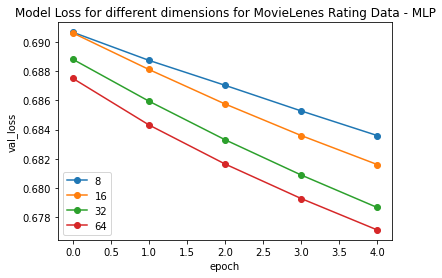

In [ ]:
# 'new_output' is a dataframe with stacked validation losses fro different Embedding Dimensions
val_losses_data_ML = pd.DataFrame(new)
val_losses_data_ML['Dim'] = Embedding_size
val_losses_data_ML.set_index(['Dim'])


for i, v in val_losses_data_ML.iterrows():
  plt.plot(val_losses_data_ML['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for MovieLenes Rating Data - MLP')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_ML['Dim'], loc='lower left')
plt.show()

In [ ]:
# Training for Book Rating Dataset using MLP (NCF-II)
Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = MLP(br_num_users, br_num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.0001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])

Epoch 1/5
6288/6288 [==============================] - 32s 5ms/step - loss: 0.6804 - val_loss: 0.6676
Epoch 2/5
6288/6288 [==============================] - 32s 5ms/step - loss: 0.6581 - val_loss: 0.6492
Epoch 3/5
6288/6288 [==============================] - 31s 5ms/step - loss: 0.6418 - val_loss: 0.6345
Epoch 4/5
6288/6288 [==============================] - 31s 5ms/step - loss: 0.6287 - val_loss: 0.6229
Epoch 5/5
6288/6288 [==============================] - 32s 5ms/step - loss: 0.6187 - val_loss: 0.6144
Epoch 1/5
6288/6288 [==============================] - 47s 7ms/step - loss: 0.6730 - val_loss: 0.6570
Epoch 2/5
6288/6288 [==============================] - 42s 7ms/step - loss: 0.6459 - val_loss: 0.6357
Epoch 3/5
6288/6288 [==============================] - 47s 7ms/step - loss: 0.6283 - val_loss: 0.6214
Epoch 4/5
6288/6288 [==============================] - 42s 7ms/step - loss: 0.6170 - val_loss: 0.6129
Epoch 5/5
6288/6288 [==============================] - 47s 7ms/step - loss: 0.6107

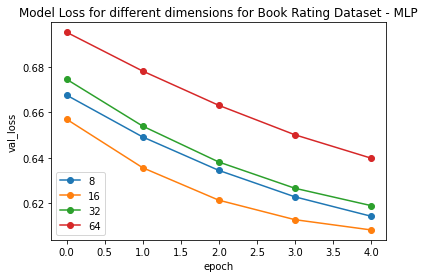

In [ ]:
# 'new_output' is a dataframe with stacked validation losses fro different Embedding Dimensions
val_losses_data_ML = pd.DataFrame(new)
val_losses_data_ML['Dim'] = Embedding_size
val_losses_data_ML.set_index(['Dim'])


for i, v in val_losses_data_ML.iterrows():
  plt.plot(val_losses_data_ML['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for Book Rating Dataset - MLP')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_ML['Dim'], loc='lower left')
plt.show()

#**Combining the GMF and MLP to consolitdate the version of Neural Collaborative Filtering (NCF)**

In [ ]:
# Change the dataset name as per the interest - movielens dataset > ratings, book rating dataset > book_rating_data

rating = book_rating_data  #Change it to different dataset accordingly
rating["rating"] = rating["rating"].values.astype(np.float32)

min_rating = min(rating["rating"])
max_rating = max(rating["rating"])

# Creation of train and validation dataset
data = rating.sample(frac=1, random_state=1)
x = data[["user","item"]].values
y = data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#y = data["rating"]


train_indices = int(0.7 * data.shape[0])

x_train, x_val, y_train, y_val = (x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:])

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(804846, 2)
(804846,)
(344934, 2)
(344934,)


In [ ]:
# Model creation combining GMF and MLP
class NCF(keras.Model):
  def __init__(self, num_users, num_items, embedding_size, **kwargs):
    super(NCF, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_size = embedding_size
    self.user_embed = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.item_embed = layers.Embedding(
        num_items,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.item_bias = layers.Embedding(num_items, 1)
    #MLP layers
    self.layer1 = Dense(256, activation='relu')
    self.layer2 = Dense(128, activation='relu')
    self.layer3 = Dense(64, activation='relu')
    #self.layer4 = Dense(32, activation='relu')
    self.output_layer = Dense(1, activation='sigmoid')



  def call(self, inputs):
    user_vector = self.user_embed(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    item_vector = self.item_embed(inputs[:,1])
    item_bias = self.item_bias(inputs[:,1])
    GMF_output = user_vector * item_vector
    MLP_output = layers.Concatenate()([user_vector ,item_vector])
    MLP_out1 = self.layer1(MLP_output)
    MLP_out2 = self.layer2(MLP_out1)
    MLP_out3 = self.layer3(MLP_out2)
    #MLP_out4 = self.layer4(MLP_out3)
    final_input = layers.Concatenate()([GMF_output, MLP_out3])
    final_output = self.output_layer(final_input)

    #x = new #+ user_bias + item_bias
    return final_output

In [ ]:
# Training for Book Rating Dataset using GMF + MLP (NCF)
Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = NCF(num_users, num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.0001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])

Epoch 1/5


276/276 [==============================] - 2s 5ms/step - loss: 0.6915 - val_loss: 0.6901
Epoch 2/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6888 - val_loss: 0.6877
Epoch 3/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6866 - val_loss: 0.6857
Epoch 4/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6847 - val_loss: 0.6839
Epoch 5/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6831 - val_loss: 0.6823
Epoch 1/5


276/276 [==============================] - 2s 5ms/step - loss: 0.6927 - val_loss: 0.6918
Epoch 2/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6911 - val_loss: 0.6904
Epoch 3/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6898 - val_loss: 0.6892
Epoch 4/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6886 - val_loss: 0.6881
Epoch 5/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6876 - val_loss: 0.6872
Epoch 1/5


276/276 [==============================] - 2s 5ms/step - loss: 0.6919 - val_loss: 0.6913
Epoch 2/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6907 - val_loss: 0.6903
Epoch 3/5
276/276 [==============================] - 1s 5ms/step - loss: 0.6898 - val_loss: 0.6894
Epoch 4/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6889 - val_loss: 0.6885
Epoch 5/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6881 - val_loss: 0.6877
Epoch 1/5


276/276 [==============================] - 2s 5ms/step - loss: 0.6915 - val_loss: 0.6909
Epoch 2/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6903 - val_loss: 0.6898
Epoch 3/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6893 - val_loss: 0.6888
Epoch 4/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6884 - val_loss: 0.6879
Epoch 5/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6875 - val_loss: 0.6871


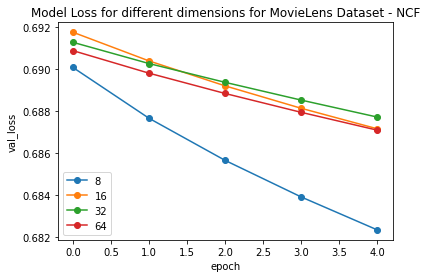

In [ ]:
# 'new_output' is a dataframe with stacked validation losses for different Embedding Dimensions
val_losses_data_ML = pd.DataFrame(new)
val_losses_data_ML['Dim'] = Embedding_size
val_losses_data_ML.set_index(['Dim'])


for i, v in val_losses_data_ML.iterrows():
  plt.plot(val_losses_data_ML['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for MovieLens Dataset - NCF')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_ML['Dim'], loc='lower left')
plt.show()

In [ ]:
# Training for Book Rating Dataset using GMF + MLP (NCF)
Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = NCF(br_num_users, br_num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(lr=0.0001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])

Epoch 1/5


6288/6288 [==============================] - 37s 6ms/step - loss: 0.6769 - val_loss: 0.6626
Epoch 2/5
6288/6288 [==============================] - 36s 6ms/step - loss: 0.6525 - val_loss: 0.6431
Epoch 3/5
6288/6288 [==============================] - 31s 5ms/step - loss: 0.6356 - val_loss: 0.6284
Epoch 4/5
6288/6288 [==============================] - 36s 6ms/step - loss: 0.6229 - val_loss: 0.6176
Epoch 5/5
6288/6288 [==============================] - 36s 6ms/step - loss: 0.6140 - val_loss: 0.6103
Epoch 1/5


6288/6288 [==============================] - 47s 7ms/step - loss: 0.6768 - val_loss: 0.6615
Epoch 2/5
6288/6288 [==============================] - 42s 7ms/step - loss: 0.6502 - val_loss: 0.6399
Epoch 3/5
6288/6288 [==============================] - 47s 7ms/step - loss: 0.6322 - val_loss: 0.6250
Epoch 4/5
6288/6288 [==============================] - 46s 7ms/step - loss: 0.6200 - val_loss: 0.6152
Epoch 5/5
6288/6288 [==============================] - 49s 8ms/step - loss: 0.6125 - val_loss: 0.6096
Epoch 1/5


6288/6288 [==============================] - 67s 11ms/step - loss: 0.6902 - val_loss: 0.6794
Epoch 2/5
6288/6288 [==============================] - 69s 11ms/step - loss: 0.6710 - val_loss: 0.6629
Epoch 3/5
6288/6288 [==============================] - 69s 11ms/step - loss: 0.6556 - val_loss: 0.6484
Epoch 4/5
6288/6288 [==============================] - 66s 10ms/step - loss: 0.6423 - val_loss: 0.6362
Epoch 5/5
6288/6288 [==============================] - 63s 10ms/step - loss: 0.6315 - val_loss: 0.6266
Epoch 1/5


6288/6288 [==============================] - 105s 17ms/step - loss: 0.7013 - val_loss: 0.6901
Epoch 2/5
6288/6288 [==============================] - 104s 16ms/step - loss: 0.6808 - val_loss: 0.6720
Epoch 3/5
6288/6288 [==============================] - 103s 16ms/step - loss: 0.6644 - val_loss: 0.6570
Epoch 4/5
6288/6288 [==============================] - 103s 16ms/step - loss: 0.6510 - val_loss: 0.6450
Epoch 5/5
6288/6288 [==============================] - 103s 16ms/step - loss: 0.6405 - val_loss: 0.6360


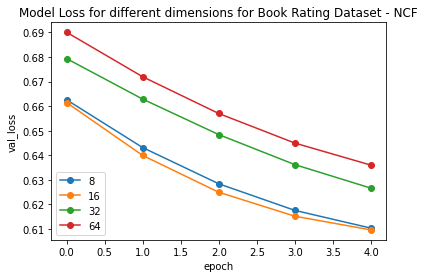

In [ ]:
val_losses_data_ML = pd.DataFrame(new)
val_losses_data_ML['Dim'] = Embedding_size
val_losses_data_ML.set_index(['Dim'])


for i, v in val_losses_data_ML.iterrows():
  plt.plot(val_losses_data_ML['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for Book Rating Dataset - NCF')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_ML['Dim'], loc='lower left')
plt.show()